<a href="https://colab.research.google.com/github/dariashcherbakovaaa/MA_DSE_Unimi/blob/Algo/Page_Rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import findspark
findspark.init("spark-3.1.1-bin-hadoop3.2")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

sc = spark.sparkContext

In [2]:
import numpy as np
np.set_printoptions(precision=3)
np.array([.12333122, .13432221, .64442143])

array([0.123, 0.134, 0.644])

In [3]:
labels = ['A', 'B', 'C', 'D',  'E', 'F', 'G']

pages = range(len(labels))

# this dictionary assiciates number in pages to labels
page_labels = {p: l for p, l in zip(pages, labels)}
page_labels

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'}

In [4]:
links = [(1, 0), (3, 0),
         (0, 1), (5, 2),
         (6, 2), (6, 5),
         (5, 6), (2, 6),
         (0, 6), (5, 4), (4, 3)]

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()

for p in pages:
    g.add_node(p)

for (a, b) in links:
    g.add_edge(pages[a], pages[b])

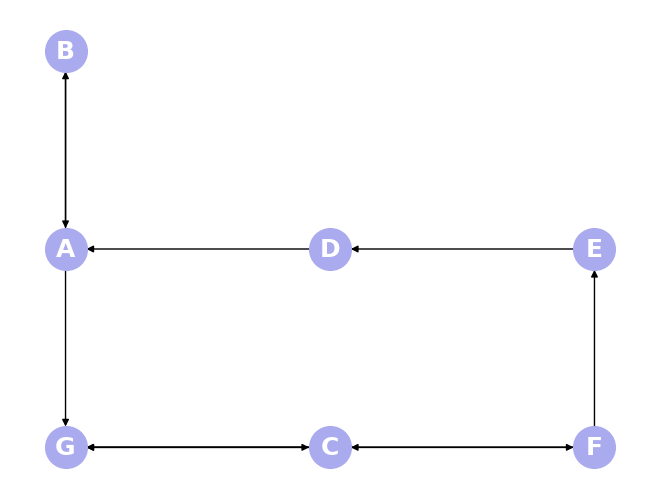

In [6]:
opts = {'node_size': 900,
        'font_color': 'w',
        'font_size': 18,
        'font_weight': 'bold'}

pos = {0: (0, 1), 1: (0, 2), 2: (1, 0),
       3: (1, 1), 4: (2, 1), 5: (2, 0), 6: (0, 0)}

nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos, node_color='#AAAAEE', **opts)
plt.show()

In [7]:
adjacency = {}
for u in range(len(pages)):
    adjacency[u] = []

for (a, b) in links:
    adjacency[a].append(b)

print(adjacency)

{0: [1, 6], 1: [0], 2: [6], 3: [0], 4: [3], 5: [2, 6, 4], 6: [2, 5]}


In [8]:
connection_matrix = []
for a in adjacency:
    for b in adjacency[a]:
        # this builds the transition matrix (beware of indices!)
        connection_matrix.append((b, a, 1./len(adjacency[a])))
connection_matrix

[(1, 0, 0.5),
 (6, 0, 0.5),
 (0, 1, 1.0),
 (6, 2, 1.0),
 (0, 3, 1.0),
 (3, 4, 1.0),
 (2, 5, 0.3333333333333333),
 (6, 5, 0.3333333333333333),
 (4, 5, 0.3333333333333333),
 (2, 6, 0.5),
 (5, 6, 0.5)]

*cache the intermediate results of the transformation so that other transformation runs on top of cached will perform faster. Caching the result of the transformation is one of the optimization tricks to improve the performance of the long-running PySpark applications/jobs.*

In [9]:
links_RDD = sc.parallelize(connection_matrix).cache()

broadcast operation by creating broadcast variable, which we can only read